# 1. Introduction

* unique_key: A unique identifier for each collision.
* date, time: Date and time of the collision.
* borough: The borough, or area of New York City, where the collision occurred.
* location: Latitude and longitude coordinates for the collision.
* on_street, cross_street, off_street: Details of the street or intersection where the collision occurred.
* pedestrians_injured: Number of pedestrians who were injured.
* cyclist_injured: Number of people traveling on a bicycle who were injured.
* motorist_injured: Number of people traveling in a vehicle who were injured.
* total_injured: Total number of people injured.
* pedestrians_killed: Number of pedestrians who were killed.
* cyclist_killed: Number of people traveling on a bicycle who were killed.
* motorist_killed: Number of people traveling in a vehicle who were killed.
* total_killed: Total number of people killed.
* vehicle_1 through vehicle_5: Type of each vehicle involved in the accident.
* cause_vehicle_1 through cause_vehicle_5: Contributing factor for each vehicle in the accident.


In [1]:
import pandas as pd
mvc = pd.read_csv("nypd_mvc_2018.csv")

null_counts=mvc.isnull().sum()

# 2. Verifying the Total Columns

In [2]:
killed_cols = [col for col in mvc.columns if 'killed' in col]
killed = mvc[killed_cols].copy()

print(killed)

killed_manual_sum=killed.iloc[:,:3].sum(axis=1)

killed_mask=killed_manual_sum!=killed["total_killed"]

killed_non_eq=killed[killed_mask]

print(killed_non_eq)

       pedestrians_killed  cyclist_killed  motorist_killed  total_killed
0                       0               0                0           0.0
1                       0               0                0           0.0
2                       0               0                0           0.0
3                       0               0                0           0.0
4                       0               0                0           0.0
...                   ...             ...              ...           ...
57859                   0               0                0           0.0
57860                   0               0                0           0.0
57861                   0               0                0           0.0
57862                   0               0                0           0.0
57863                   0               0                0           0.0

[57864 rows x 4 columns]
       pedestrians_killed  cyclist_killed  motorist_killed  total_killed
3508                    0

# 3. Filling and Verifying the Killed and Injured Data

In [3]:
import numpy as np

# fix the killed values
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'].isnull(), killed_manual_sum)
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'] != killed_manual_sum, np.nan)

# Create an injured dataframe and manually sum values
injured = mvc[[col for col in mvc.columns if 'injured' in col]].copy()
injured_manual_sum = injured.iloc[:,:3].sum(axis=1)

injured["total_injured"]=injured["total_injured"].mask(injured["total_injured"].isnull(),injured_manual_sum)
injured["total_injured"]=injured["total_injured"].mask(injured["total_injured"]!=injured_manual_sum,np.nan)

# 4. Assigning the Corrected Data Back to the Main Dataframe

In [4]:
mvc["total_injured"]=injured["total_injured"]
mvc["total_killed"]=killed["total_killed"]

# 5. Visualizing Missing Data with Plots

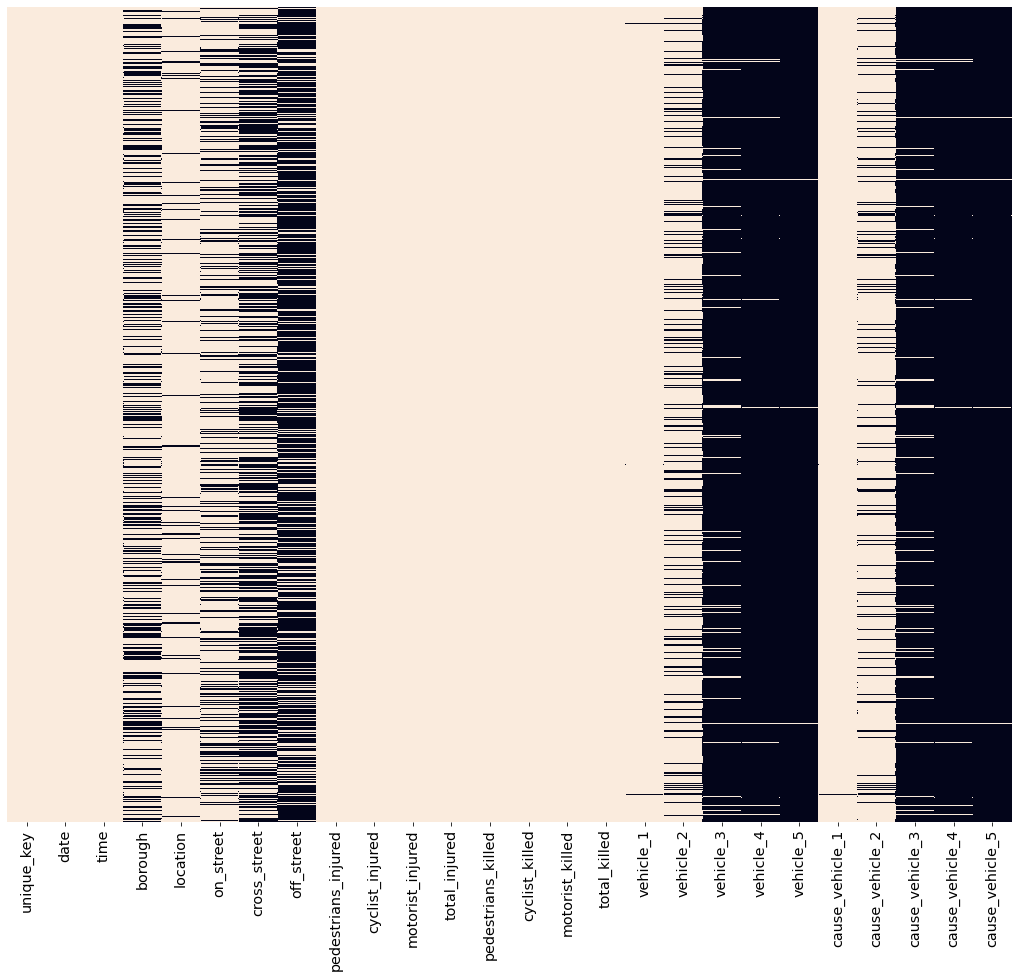

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_null_matrix(df, figsize=(18,15)):
    # initiate the figure
    plt.figure(figsize=figsize)
    # create a boolean dataframe based on whether values are null
    df_null = df.isnull()
    # create a heatmap of the boolean dataframe
    sns.heatmap(~df_null, cbar=False, yticklabels=False)
    plt.xticks(rotation=90, size='x-large')
    plt.show()
    
plot_null_matrix(mvc)

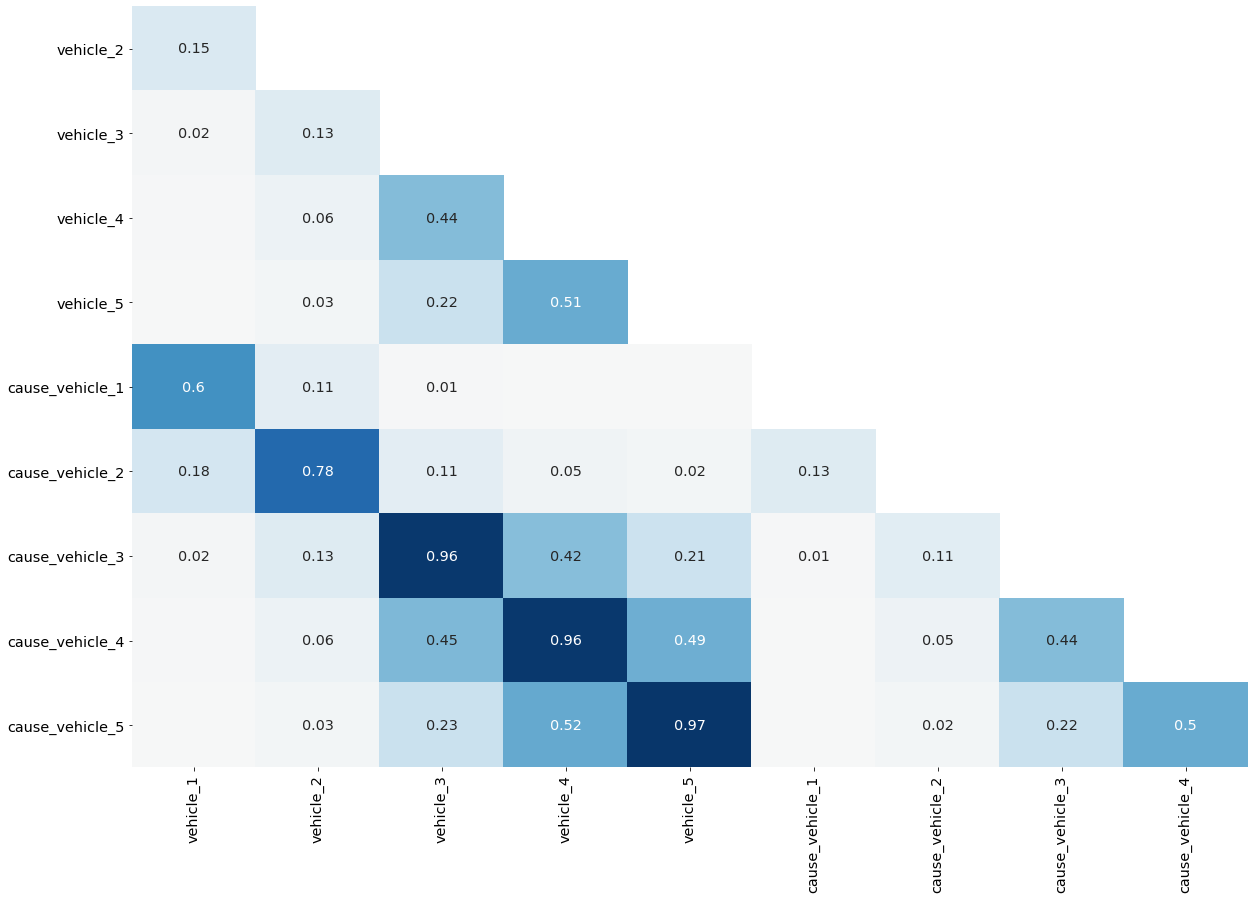

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_null_correlations(df):
    # create a correlation matrix only for columns with at least
    # one missing value
    cols_with_missing_vals = df.columns[df.isnull().sum() > 0]
    missing_corr = df[cols_with_missing_vals].isnull().corr()
    
    # create a mask to avoid repeated values and make
    # the plot easier to read
    missing_corr = missing_corr.iloc[1:, :-1]
    mask = np.triu(np.ones_like(missing_corr), k=1)
    
    # plot a heatmap of the values
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(missing_corr, vmin=-1, vmax=1, cbar=False,
                     cmap='RdBu', mask=mask, annot=True)
    
    # format the text in the plot to make it easier to read
    for text in ax.texts:
        t = float(text.get_text())
        if -0.05 < t < 0.01:
            text.set_text('')
        else:
            text.set_text(round(t, 2))
        text.set_fontsize('x-large')
    plt.xticks(rotation=90, size='x-large')
    plt.yticks(rotation=0, size='x-large')

    plt.show()
    
vehicles=[col for col in mvc.columns if "vehicle" in col]

plot_null_correlations(mvc[vehicles])

# 6. Analyzing Correlations in Missing Data

In [16]:
col_labels = ['v_number', 'vehicle_missing', 'cause_missing']

vc_null_data = []
v_null=0
c_null=0

for v in range(1,6):
    v_col = 'vehicle_{}'.format(v)
    c_col = 'cause_vehicle_{}'.format(v)
    
    v_null = (mvc[v_col].isnull() & mvc[c_col].notnull()).sum()
    c_null = (mvc[c_col].isnull() & mvc[v_col].notnull()).sum()
    
    vc_null_data.append([v, v_null, c_null])
    
vc_null_df=pd.DataFrame(vc_null_data, columns=col_labels)

print(vc_null_df)

   v_number  vehicle_missing  cause_missing
0         1              204             24
1         2             3793            223
2         3              242             24
3         4               50              3
4         5               10              0


# 7. Finding the Most Common Values Across Multiple Columns

In [22]:
v_cols = [c for c in mvc.columns if c.startswith("vehicle")]

top10_vehicles=mvc[v_cols].stack().value_counts()[:10]

print(top10_vehicles)

Sedan                                  33133
Station Wagon/Sport Utility Vehicle    26124
PASSENGER VEHICLE                      16026
SPORT UTILITY / STATION WAGON          12356
Taxi                                    3482
Pick-up Truck                           2373
TAXI                                    1892
Box Truck                               1659
Bike                                    1190
Bus                                     1162
dtype: int64


# 8. Filling Unknown Values with a Placeholder

In [26]:
def summarize_missing():
    v_missing_data = []

    for v in range(1,6):
        v_col = 'vehicle_{}'.format(v)
        c_col = 'cause_vehicle_{}'.format(v)

        v_missing = (mvc[v_col].isnull() & mvc[c_col].notnull()).sum()
        c_missing = (mvc[c_col].isnull() & mvc[v_col].notnull()).sum()

        v_missing_data.append([v, v_missing, c_missing])

    col_labels = columns=["vehicle_number", "vehicle_missing", "cause_missing"]
    return pd.DataFrame(v_missing_data, columns=col_labels)

summary_before = summarize_missing()

for v in range(1,6):
    v_col = 'vehicle_{}'.format(v)
    c_col = 'cause_vehicle_{}'.format(v)
    
    v_missing=(mvc[v_col].isnull() & mvc[c_col].notnull())
    c_missing=(mvc[c_col].isnull() & mvc[v_col].notnull())
    
    mvc[v_col]=mvc[v_col].mask(v_missing, "Unspecified")
    mvc[c_col]=mvc[c_col].mask(c_missing, "Unspecified")
    
summary_after=summarize_missing()

print(summary_after)

   vehicle_number  vehicle_missing  cause_missing
0               1                0              0
1               2                0              0
2               3                0              0
3               4                0              0
4               5                0              0


# 9. Missing Data in the "Location" Columns

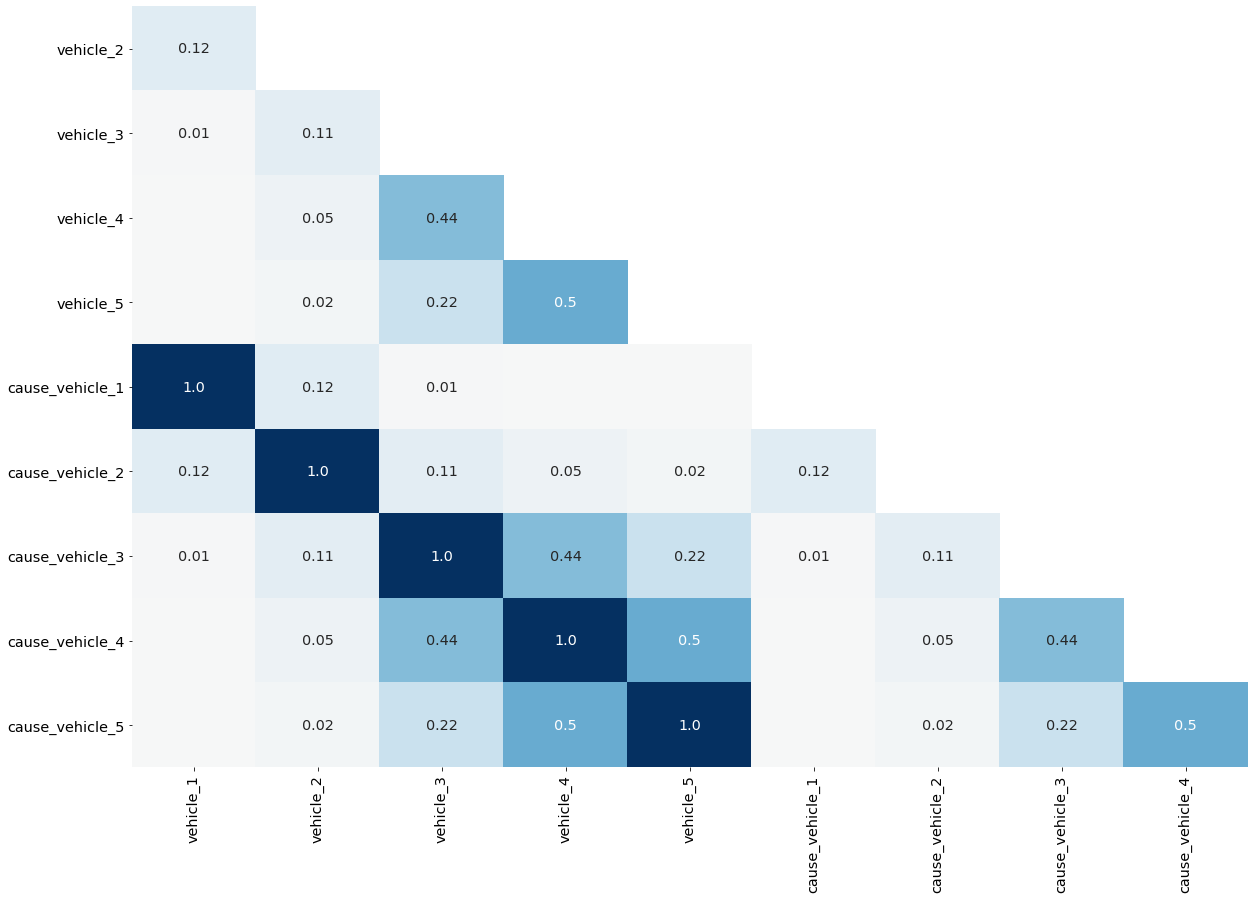

In [27]:
veh_cols = [c for c in mvc.columns if 'vehicle' in c]
plot_null_correlations(mvc[veh_cols])

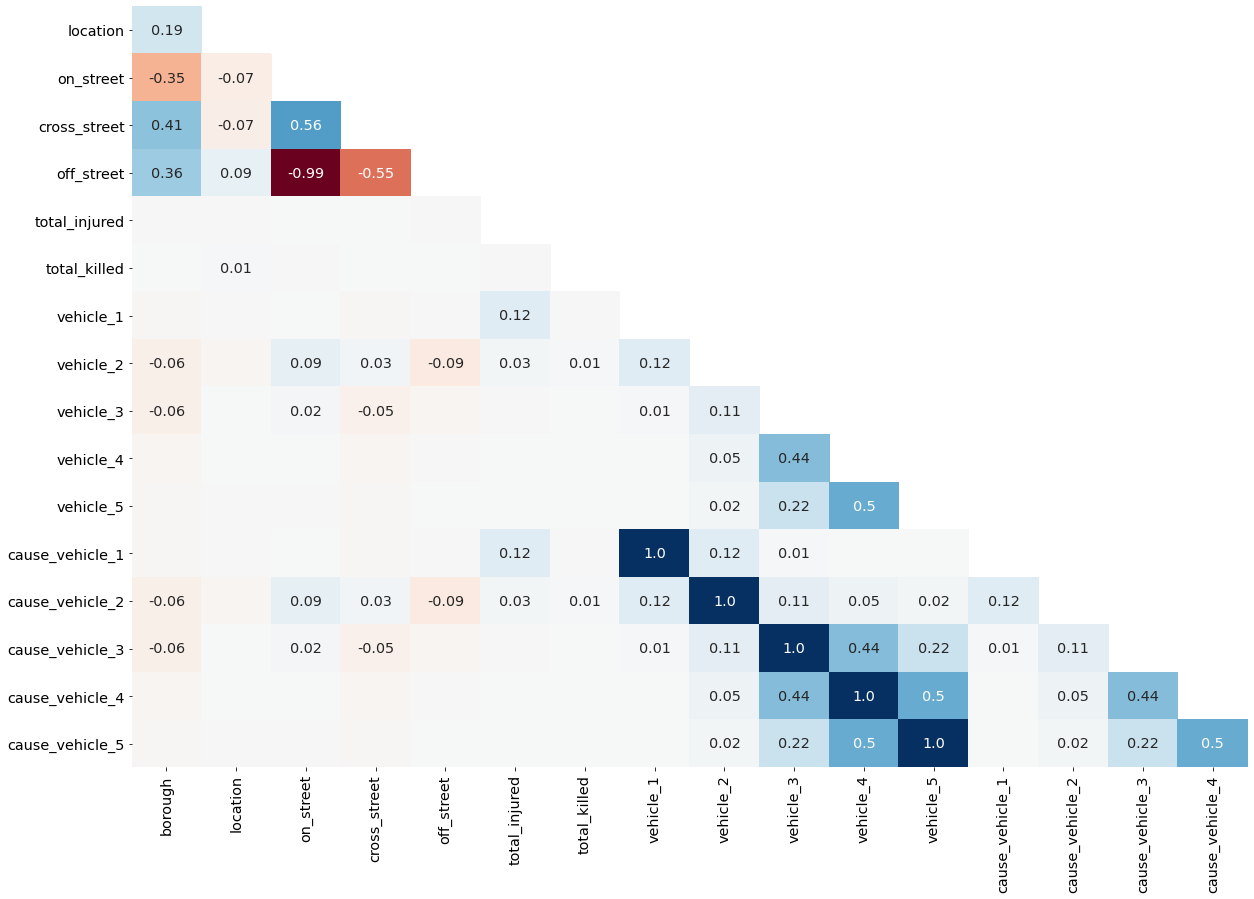

In [29]:
plot_null_correlations(mvc)

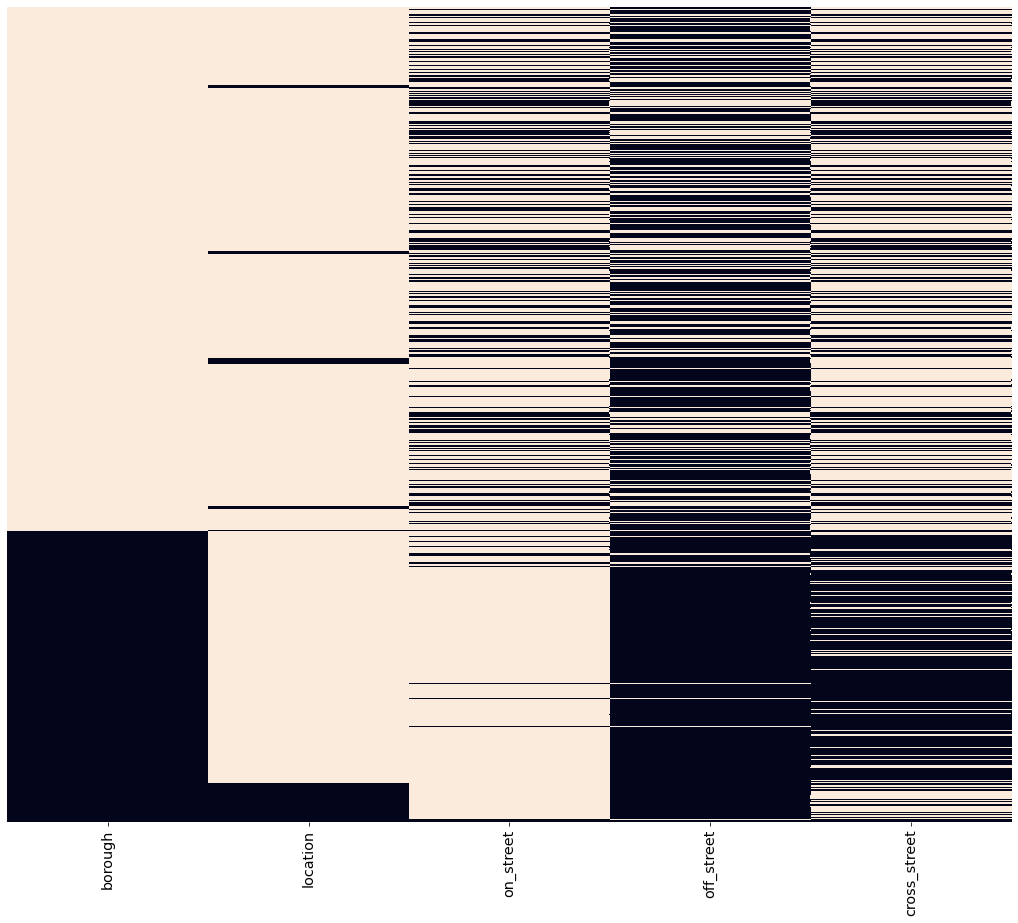

In [31]:
loc_cols = ['borough', 'location', 'on_street', 'off_street', 'cross_street']
location_data = mvc[loc_cols]

sorted_location_data = location_data.sort_values(loc_cols)
plot_null_matrix(sorted_location_data)

Let's make some observations about the missing values across these columns:

* About two-thirds of rows have non-null values for borough, but of those values that are missing, most have non-null values for location and one or more of the street name columns.
* Less than one-tenth of rows have missing values in the location column, but most of these have non-null values in one or more of the street name columns.
* Most rows have a non-null value for either on_street or off_street, and some also have a value for cross_street.

Combined, this means that we will be able to impute a lot of the missing values by using the other columns in each row. To do this, we can use geolocation APIs that take either an address or location coordinates, and return information about that location.

Because the focus of this lesson is working with missing data, we have pre-prepared supplemental data using APIs. On the next screen, we'll learn more about how that data was prepared and then use it to fill in missing values.

# 10. Imputing Location Data

We prepared the supplemental data using the GeoPy package, which makes working with Geocoding APIs like the Google Maps API easier. Here's the strategy we used to prepare the supplemental data:

* For rows with location values but missing values in either borough or the street name columns, we used geocoding APIs to look up the location coordinates to find the missing data.

* For rows with values in the street name columns missing borough and/or location data, we used geocoding APIs to look up the address to find the missing data.


In [39]:
sup_data = pd.read_csv('supplemental_data.csv')

location_cols = ['location', 'on_street', 'off_street', 'borough']
null_before = mvc[location_cols].isnull().sum()

print(sup_data)

for col in location_cols:
    mvc[col]=mvc[col].mask(mvc[col].isnull(), sup_data[col])
    
null_after=mvc[location_cols].isnull().sum()

print("Null Before", null_before, "Null After", null_after, sep="\n")

       unique_key location                   on_street       off_street  \
0         3869058      NaN                         NaN              NaN   
1         3847947      NaN                         NaN              NaN   
2         3914294      NaN                BELT PARKWAY              NaN   
3         3915069      NaN                         NaN              NaN   
4         3923123      NaN                         NaN              NaN   
...           ...      ...                         ...              ...   
57859     3835191      NaN                         NaN              NaN   
57860     3890674      NaN                         NaN              NaN   
57861     3946458      NaN                         NaN      40 PARK ROW   
57862     3914574      NaN  BROOKLYN-QUEENS EXPRESSWAY              NaN   
57863     4034882      NaN                         NaN  360 FULTON MALL   

         borough  
0            NaN  
1            NaN  
2       BROOKLYN  
3            NaN  
4   

# 11. Next Steps

If you'd like to continue working with this data, you can:

* Drop the rows that had suspect values for injured and killed totals.
* Clean the values in the vehicle_1 through vehicle_5 columns by analyzing the different values and merging duplicates and near-duplicates.
* Analyze whether collisions are more likely in certain locations, at certain times, or for certain vehicle types.